In [1]:
# 'Block 1' Graph Generation (and some random Plotting Graphs) + Distance Calculations 
import numpy as np
import random
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import ast  # To safely evaluate string representations of lists

# Load the synthetic data from an Excel file
file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_data.xlsx'
df = pd.read_excel(file_path)

# Function to convert string representation of list to an actual list
def str_to_list(s):
    return ast.literal_eval(s)

# Convert the string lists to actual lists
df['Activities'] = df['Activities'].apply(str_to_list)
df['Durations'] = df['Durations'].apply(str_to_list)

# Distance calculation function
def graph_edit_distance(G1, G2, alpha=1, beta=1, gamma=1, delta=1, epsilon=1):
    # Helper function to calculate node label distance
    def node_label_distance(l1, l2):
        return 0 if l1 == l2 else 1

    # Cost functions
    def node_insertion_cost(node):
        return alpha * G2.nodes[node]['size']

    def node_deletion_cost(node):
        return alpha * G1.nodes[node]['size']

    def node_substitution_cost(node1, node2):
        label_cost = beta * node_label_distance(G1.nodes[node1]['label'], G2.nodes[node2]['label'])
        size_cost = gamma * abs(G1.nodes[node1]['size'] - G2.nodes[node2]['size'])
        return label_cost + size_cost

    def edge_insertion_cost(edge):
        return delta * G2.edges[edge]['weight']

    def edge_deletion_cost(edge):
        return delta * G1.edges[edge]['weight']

    def edge_substitution_cost(edge1, edge2):
        weight_cost = epsilon * abs(G1.edges[edge1]['weight'] - G2.edges[edge2]['weight'])
        return weight_cost

    # Calculate node edit costs
    node_costs = np.zeros((len(G1.nodes), len(G2.nodes)))
    for i, node1 in enumerate(G1.nodes):
        for j, node2 in enumerate(G2.nodes):
            node_costs[i, j] = node_substitution_cost(node1, node2)
    
    # Hungarian algorithm to find minimum node substitution cost
    row_ind, col_ind = linear_sum_assignment(node_costs)
    node_sub_cost = node_costs[row_ind, col_ind].sum()

    # Node insertion and deletion costs
    node_ins_cost = sum(node_insertion_cost(node) for node in G2.nodes if node not in G1.nodes)
    node_del_cost = sum(node_deletion_cost(node) for node in G1.nodes if node not in G2.nodes)

    # Calculate edge edit costs
    edge_costs = np.zeros((len(G1.edges), len(G2.edges)))
    for i, edge1 in enumerate(G1.edges):
        for j, edge2 in enumerate(G2.edges):
            edge_costs[i, j] = edge_substitution_cost(edge1, edge2)
    
    # Hungarian algorithm to find minimum edge substitution cost
    row_ind, col_ind = linear_sum_assignment(edge_costs)
    edge_sub_cost = edge_costs[row_ind, col_ind].sum()

    # Edge insertion and deletion costs
    edge_ins_cost = sum(edge_insertion_cost(edge) for edge in G2.edges if edge not in G1.edges)
    edge_del_cost = sum(edge_deletion_cost(edge) for edge in G1.edges if edge not in G2.edges)

    # Total edit distance
    total_cost = node_sub_cost + node_ins_cost + node_del_cost + edge_sub_cost + edge_ins_cost + edge_del_cost

    return total_cost


# Generate graphs for each day
daily_graphs = {}
for day_index, day_data in df.iterrows():
    activities = day_data['Activities']
    durations = day_data['Durations']
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with combined sizes for the same activity
    activity_durations = {}
    for activity, duration in zip(activities, durations):
        if activity in activity_durations:
            activity_durations[activity] += duration
        else:
            activity_durations[activity] = duration

    for activity, total_duration in activity_durations.items():
        G.add_node(activity, label=activity, size=total_duration)  # Adding label attribute

    # Add edges with weights representing the number of transitions
    for i in range(len(activities) - 1):
        if G.has_edge(activities[i], activities[i + 1]):
            G[activities[i]][activities[i + 1]]['weight'] += 1
        else:
            G.add_edge(activities[i], activities[i + 1], weight=1)
    
    daily_graphs[day_index] = G


# Calculate graph edit distances
max_lag = 7
edit_distances = {f"i-{lag}": [] for lag in range(1, max_lag + 1)}

for i in range(max_lag, len(daily_graphs)):
    for lag in range(1, max_lag + 1):
        day1, day2 = i, i - lag
        G1, G2 = daily_graphs[day1], daily_graphs[day2]
        distance = graph_edit_distance(G1, G2, alpha=1, beta=1, gamma=1, delta=1, epsilon=1)
        edit_distances[f"i-{lag}"].append(distance)

# Add edit distances to DataFrame
for lag in range(1, max_lag + 1):
    column_name = f"i-{lag}"
    df[column_name] = [None] * max_lag + edit_distances[column_name]

# Save the updated DataFrame to a new Excel file
output_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_data_with_distances_1.xlsx'
df.to_excel(output_file_path, index=False)

# Plot the time series of distances
save_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData'
for lag in range(1, max_lag + 1):
    plt.figure(figsize=(12, 6))
    plt.plot(df[f"i-{lag}"], label=f"i-{lag}")
    plt.title(f"Graph Edit Distance Time Series (i-{lag})")
    plt.xlabel("Day Index")
    plt.ylabel("Graph Edit Distance")
    plt.legend()
    plt.savefig(f'{save_path}/graph_edit_distance_i-{lag}.png', dpi=300)
    plt.close()

print("Time series and updated dataset saved successfully.")


# Function to plot the graphs
def plot_path_graph(day_data, day_index, save_path):
    activities = day_data['Activities']
    durations = day_data['Durations']

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with combined sizes for the same activity
    activity_durations = {}
    for activity, duration in zip(activities, durations):
        if activity in activity_durations:
            activity_durations[activity] += duration
        else:
            activity_durations[activity] = duration

    for activity, total_duration in activity_durations.items():
        G.add_node(activity, size=total_duration)

    # Add edges with weights representing the number of transitions
    for i in range(len(activities) - 1):
        if G.has_edge(activities[i], activities[i + 1]):
            G[activities[i]][activities[i + 1]]['weight'] += 1
        else:
            G.add_edge(activities[i], activities[i + 1], weight=1)

    # Extract node sizes
    node_sizes = [G.nodes[node]['size'] for node in G.nodes]

    # Draw the graph
    pos = nx.spring_layout(G)  # You can choose different layouts
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=False, node_size=[size * 15 for size in node_sizes], node_color='skyblue', edge_color='gray', font_size=18, font_weight='bold', arrows=True)

    # Draw edge labels with weights, adding a distance offset
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=12, bbox=dict(facecolor='white', edgecolor='none', pad=0.1))

    # Draw node labels with sizes, rounding to two decimal places, and adding distance offset
    for node, (x, y) in pos.items():
        plt.text(x + 0.08, y + 0.1, f"{node}\n{round(G.nodes[node]['size'], 2)}", horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='none', pad=0.1))

    # Adjust axis limits for padding
    all_x, all_y = zip(*pos.values())
    plt.xlim(min(all_x) - 0.2, max(all_x) + 0.2)
    plt.ylim(min(all_y) - 0.2, max(all_y) + 0.2)

    # Save the plot
    plt.title(f'Path Graph for Day {day_index}')
    plt.savefig(f'{save_path}/day_{day_index}_path_graph.png', dpi=300)
    plt.close()

# Plot graphs for 3 random days
save_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData'

random_days = random.sample(range(len(df)), 3)
for day_index in random_days:
    plot_path_graph(df.iloc[day_index], day_index, save_path)

Time series and updated dataset saved successfully.


In [2]:
#  'Block 2'  Extraction of Residuals 

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset with distances
output_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_data_with_distances_1.xlsx'
df = pd.read_excel(output_file_path)

# Function to detect anomalies using seasonal decomposition
def detect_anomalies_seasonal_decomposition(series, period=7):
    series_filled = series.ffill().bfill()  # Fill missing values
    result = seasonal_decompose(series_filled, model='additive', period=period)
    resid = result.resid
    resid = resid.dropna()
    
    threshold = 3 * np.std(resid)
    anomalies = abs(resid) > threshold
    return anomalies, resid

# Extraction of residuals for each distance time series and add them as columns
residual_columns = []
for lag in range(1, 8):
    column_name = f"i-{lag}"
    anomalies, resid = detect_anomalies_seasonal_decomposition(df[column_name])
    df[f"anomaly {column_name}"] = anomalies.astype(int)
    residual_column_name = f"res {column_name}"
    df[residual_column_name] = resid
    residual_columns.append(residual_column_name)


In [26]:
#  'Block 3' Multivariate Anomaly Calculations on Residuals By Isolation Forest Method

# Prepare the data for multivariate anomaly detection
X = df[residual_columns].dropna().values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest model
clf = IForest(contamination=0.01)  # Adjust contamination based on expected anomaly rate
clf.fit(X_scaled)

# Predict anomalies and add them as a new column
df['Multivariate Anomaly'] = 0
df.loc[df[residual_columns].dropna().index, 'Multivariate Anomaly'] = clf.predict(X_scaled)

# Save the updated DataFrame to a new Excel file
output_file_with_anomalies_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_IsolationForest_anomalies.xlsx'
df.to_excel(output_file_with_anomalies_path, index=False)


In [7]:
# 'Block 4' Multivariate Anomaly Calculations on Residuals By Mahalanobis Distance Method

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler

# Prepare the data for multivariate anomaly detection
X = df[residual_columns].dropna().values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(X_scaled, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for each observation
mean_distr = np.mean(X_scaled, axis=0)
mahalanobis_distances = np.apply_along_axis(mahalanobis, 1, X_scaled, mean_distr, inv_cov_matrix)

# Determine the threshold for anomalies based on chi-squared distribution
# threshold = chi2.ppf((1 - 0.37), df=X_scaled.shape[1])  # Adjust contamination rate as needed
threshold = chi2.ppf((1 - 0.06), df=X_scaled.shape[1])  # Adjust contamination rate as needed

# Identify anomalies
anomalies = mahalanobis_distances > threshold

# Add the anomalies as a new column in the DataFrame
df['Multivariate Anomaly'] = 0
df.loc[df[residual_columns].dropna().index, 'Multivariate Anomaly'] = anomalies.astype(int)

# Save the updated DataFrame to a new Excel file
output_file_with_anomalies_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_Mahalanobis_anomalies.xlsx'
df.to_excel(output_file_with_anomalies_path, index=False)

print("Anomalies detected and dataset saved successfully.")

Anomalies detected and dataset saved successfully.


In [38]:
# 'Block 5' Multivariate Anomaly Calculations on Residuals By Local Outlier Factor Method

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Prepare the data for multivariate anomaly detection
X = df[residual_columns].dropna().values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit LOF model
lof = LocalOutlierFactor(n_neighbors=7, contamination=0.01)  # Adjust n_neighbors and contamination as needed
y_pred = lof.fit_predict(X_scaled)

# LOF returns -1 for outliers and 1 for inliers
anomalies = y_pred == -1

# Add the anomalies as a new column in the DataFrame
df['Multivariate Anomaly'] = 0
df.loc[df[residual_columns].dropna().index, 'Multivariate Anomaly'] = anomalies.astype(int)


# Save the updated DataFrame to a new Excel file
output_file_with_anomalies_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_Local_Outlier_Factor_anomalies.xlsx'
df.to_excel(output_file_with_anomalies_path, index=False)

print("Anomalies detected and dataset saved successfully.")

Anomalies detected and dataset saved successfully.


In [8]:
# 'Block 6' Counting the Number of Anomalies (those days with Multivariate Anomaly == 1)
count_of_ones = (df['Multivariate Anomaly'] == 1).sum()
print ("NumberOfDaysWithInherentAnomaly : " , count_of_ones)

# anomaly_columns = ["Multivariate Anomaly"] + [f"anomaly i-{lag}" for lag in range(1, 8)]

valid_days = []
for i in range(7, len(df)):
    if df['Multivariate Anomaly'].iloc[i] == 0 and all(df['Multivariate Anomaly'].iloc[i - j] == 0 for j in range(1, 8)):
        valid_days.append(i)

NumberOfDaysThatCanBeChosenToAddSyntheticAnomaly = (len(valid_days))
print ("NumberOfDaysThatCanBeChosenToAddSyntheticAnomaly : " , NumberOfDaysThatCanBeChosenToAddSyntheticAnomaly)


NumberOfDaysWithInherentAnomaly :  0
NumberOfDaysThatCanBeChosenToAddSyntheticAnomaly :  9993


In [81]:
# 'Block 7' Adding Manual Anomalies on Residuals (To see how good is the Multivariate Anomaly Method)
# Here we did not add anomaly on day activities but on the residuals of its edit distances with days ago (7 lag days), because our multivariate model is context aware and find anomalies based on the previous days (for example a day may have high durations or order shift in reletive to the whole dataset but reletive to its 7 days ago may not be such high, so not detect as anomaly in our model)
import pandas as pd
import random
import numpy as np

# Load the dataset
# input_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_IsolationForest_anomalies.xlsx'
# input_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_Mahalanobis_anomalies.xlsx'
input_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_Local_Outlier_Factor_anomalies.xlsx'

df = pd.read_excel(input_file_path)

# Select 100 random sample days where 'Multivariate Anomaly' is 0 
valid_days = []
for i in range(7, len(df)):
    if df['Multivariate Anomaly'].iloc[i] == 0 and all(df['Multivariate Anomaly'].iloc[i - j] == 0 for j in range(1, 8)):
        valid_days.append(i)

print(len(valid_days))
random_samples = df.loc[valid_days].sample(n=100, random_state=5).index

# Function to modify residual distances by a given percentage
def modify_residuals(df, day_indices, percentage):
    residual_columns = [f"res i-{lag}" for lag in range(1, 8)]
    for col in residual_columns:
        df[f"modified {col}"] = df[col]  # Copy original residuals to new columns

    for day in day_indices:
        for col in residual_columns:
            if not np.isnan(df.at[day, col]):  # Ensure the value is not NaN
                change_direction = random.choice([-1, 1])
                df.at[day, f"modified {col}"] *= (1 + change_direction * percentage / 100)
    
    # Add a new column to indicate synthetic anomaly
    df['synthetic anomaly'] = None
    df.loc[day_indices, 'synthetic anomaly'] = percentage

# Modify the residual distances by a given percentage (e.g., 300%)
percentage_change = 500
modify_residuals(df, random_samples, percentage_change)

# Clear data for anomalies
for lag in range(1, 8):
    df[f"i-{lag}"] = None
    df[f"anomaly i-{lag}"] = None

df["Multivariate Anomaly"] = None

# Save the updated DataFrame to a new Excel file
output_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_modifications_1.xlsx'
df.to_excel(output_file_path, index=False)

print(f"File saved to {output_file_path}")

9343
File saved to C:/Users/e16011413/OneDrive - Ulster University/Desktop/Sally UCAML/SyntheticData/synthetic_days_with_modifications_1.xlsx


In [82]:
# 'Block 8' Extraction of Modified Residuals
# Load the dataset with distances
input_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_modifications_1.xlsx'
df = pd.read_excel(input_file_path)

# Define the modified residual columns
modified_residual_columns = [f"modified res i-{lag}" for lag in range(1, 8)]

# Prepare the data for multivariate anomaly detection
X = df[modified_residual_columns].dropna().values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# 'Block 9' Multivariate Anomaly Calculations on Modified Residuals By Isolation Forest Method

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Fit Isolation Forest model
clf = IForest(contamination=0.02)  # Adjust contamination based on expected anomaly rate
clf.fit(X_scaled)

# Predict anomalies and add them as a new column
df['Modified Multivariate Anomaly'] = 0
df.loc[df[modified_residual_columns].dropna().index, 'Modified Multivariate Anomaly'] = clf.predict(X_scaled)

# Save the updated DataFrame to a new Excel file
output_file_with_anomalies_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_anomalies_2.xlsx'
df.to_excel(output_file_with_anomalies_path, index=False)

#See how was the results
count_of_ones = (df['Modified Multivariate Anomaly'] == 1).sum()
print ("Number of Detected Anomalies : ", count_of_ones)


# Filter for rows with non-empty 'synthetic anomaly' and 'Modified Multivariate Anomaly' of 1
filtered_df = df[(df['synthetic anomaly'].notna()) & (df['Modified Multivariate Anomaly'] == 1)]

# Count the number of rows in the filtered DataFrame
count = filtered_df.shape[0]

# Print the count
print("Number of Detected Synthetic Anomalies : ", count)

NameError: name 'modified_residual_columns' is not defined

In [60]:
# 'Block 10' Multivariate Anomaly Calculations on Modified Residuals By Mahalanobis Distance Method

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(X_scaled, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for each observation
mean_distr = np.mean(X_scaled, axis=0)
mahalanobis_distances = np.apply_along_axis(mahalanobis, 1, X_scaled, mean_distr, inv_cov_matrix)

# Determine the threshold for anomalies based on chi-squared distribution
threshold = chi2.ppf((1 - 0.37), df=X_scaled.shape[1])  # Adjust contamination rate as needed

# Identify anomalies
anomalies = mahalanobis_distances > threshold

# Add the anomalies as a new column in the DataFrame
df['Modified Multivariate Anomaly'] = 0
df.loc[df[residual_columns].dropna().index, 'Modified Multivariate Anomaly'] = anomalies.astype(int)

# Save the updated DataFrame to a new Excel file
output_file_with_anomalies_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_anomalies_2.xlsx'
df.to_excel(output_file_with_anomalies_path, index=False)


#See how was the results
count_of_ones = (df['Modified Multivariate Anomaly'] == 1).sum()
print ("Number of Detected Anomalies : ", count_of_ones)


# Filter for rows with non-empty 'synthetic anomaly' and 'Modified Multivariate Anomaly' of 1
filtered_df = df[(df['synthetic anomaly'].notna()) & (df['Modified Multivariate Anomaly'] == 1)]

# Count the number of rows in the filtered DataFrame
count = filtered_df.shape[0]

# Print the count
print("Number of Detected Synthetic Anomalies : ", count)

Number of Detected Anomalies :  73
Number of Detected Synthetic Anomalies :  73


In [83]:
# 'Block 11' Multivariate Anomaly Calculations on Modified Residuals By Local Outlier Factor Method

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Fit LOF model
lof = LocalOutlierFactor(n_neighbors=7, contamination=0.01)  # Adjust n_neighbors and contamination as needed
y_pred = lof.fit_predict(X_scaled)

# LOF returns -1 for outliers and 1 for inliers
anomalies = y_pred == -1

# Add the anomalies as a new column in the DataFrame
df['Modified Multivariate Anomaly'] = 0
df.loc[df[residual_columns].dropna().index, 'Modified Multivariate Anomaly'] = anomalies.astype(int)

# Save the updated DataFrame to a new Excel file
output_file_with_anomalies_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_anomalies_2.xlsx'
df.to_excel(output_file_with_anomalies_path, index=False)

#See how was the results
count_of_ones = (df['Modified Multivariate Anomaly'] == 1).sum()
print ("Number of Detected Anomalies : ", count_of_ones)


# Filter for rows with non-empty 'synthetic anomaly' and 'Modified Multivariate Anomaly' of 1
filtered_df = df[(df['synthetic anomaly'].notna()) & (df['Modified Multivariate Anomaly'] == 1)]

# Count the number of rows in the filtered DataFrame
count = filtered_df.shape[0]

# Print the count
print("Number of Detected Synthetic Anomalies : ", count)

Number of Detected Anomalies :  100
Number of Detected Synthetic Anomalies :  89


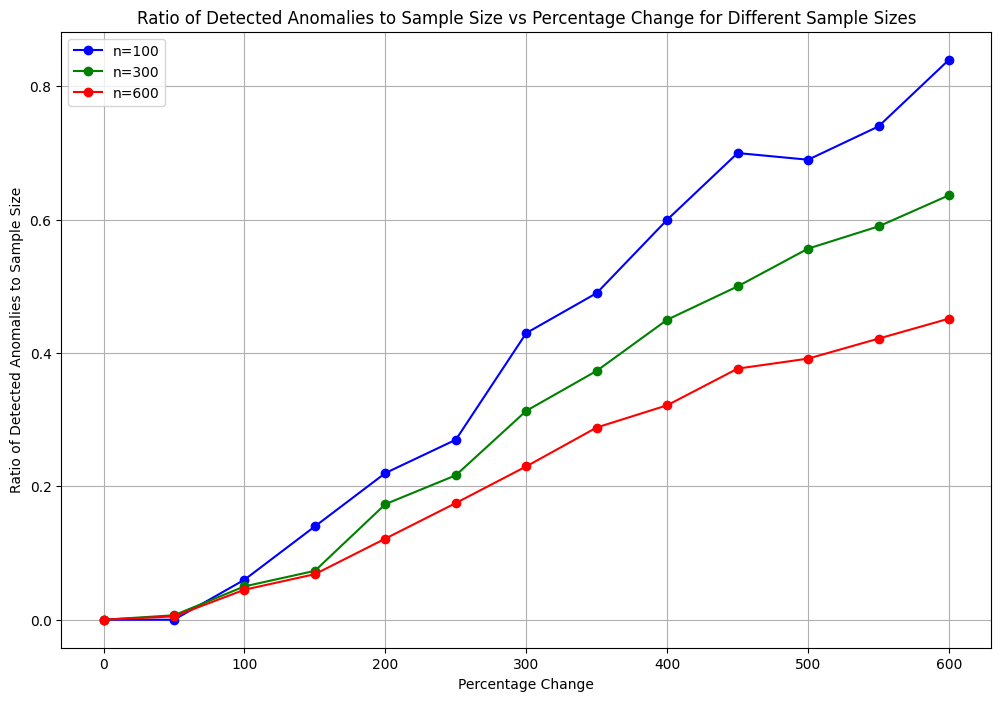

Plot saved to C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/ratio_of_detected_anomalies_vs_percentage_change_multiple_sample_sizes.png


In [16]:
# 'Block 12' Note this block is only for plot the results of Mahalanobis Distance for paper
# This block just collect all parts related to the Mahalanobis Distance and run it at once, but note *** you should run block 1, 2, 4, and 6 before runing this block ***
# because we want to plot the results for different sample size (number of synthetic anamolies) and different percentage of change
# but all with fixed chi squared alpha 0.37 for all sample sizes, that considers the upper 63% of anomalies

import pandas as pd
import numpy as np
import random
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def modify_residuals(df, day_indices, percentage):
    residual_columns = [f"res i-{lag}" for lag in range(1, 8)]
    for col in residual_columns:
        df[f"modified {col}"] = df[col]  # Copy original residuals to new columns

    for day in day_indices:
        for col in residual_columns:
            if not np.isnan(df.at[day, col]):  # Ensure the value is not NaN
                change_direction = random.choice([-1, 1])
                df.at[day, f"modified {col}"] *= (1 + change_direction * percentage / 100)
    
    # Add a new column to indicate synthetic anomaly
    df['synthetic anomaly'] = None
    df.loc[day_indices, 'synthetic anomaly'] = percentage

def detect_anomalies(df, residual_columns):
    # Define the modified residual columns
    modified_residual_columns = [f"modified res i-{lag}" for lag in range(1, 8)]

    # Prepare the data for multivariate anomaly detection
    X = df[modified_residual_columns].dropna().values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Calculate the covariance matrix and its inverse
    cov_matrix = np.cov(X_scaled, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Compute Mahalanobis distance for each observation
    mean_distr = np.mean(X_scaled, axis=0)
    mahalanobis_distances = np.apply_along_axis(mahalanobis, 1, X_scaled, mean_distr, inv_cov_matrix)

    # Determine the threshold for anomalies based on chi-squared distribution
    threshold = chi2.ppf((1 - 0.37), df=X_scaled.shape[1])  # Adjust contamination rate as needed

    # Identify anomalies
    anomalies = mahalanobis_distances > threshold

    # Add the anomalies as a new column in the DataFrame
    df['Modified Multivariate Anomaly'] = 0
    df.loc[df[residual_columns].dropna().index, 'Modified Multivariate Anomaly'] = anomalies.astype(int)

    # Count the number of detected anomalies
    count_of_ones = (df['Modified Multivariate Anomaly'] == 1).sum()
    return count_of_ones

# Load the initial dataset
input_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_Mahalanobis_anomalies.xlsx'
df = pd.read_excel(input_file_path)

# Select valid days where 'Multivariate Anomaly' is 0 and the values in the previous 7 days are also 0
valid_days = []
for i in range(7, len(df)):
    if df['Multivariate Anomaly'].iloc[i] == 0 and all(df['Multivariate Anomaly'].iloc[i - j] == 0 for j in range(1, 8)):
        valid_days.append(i)

# Define different sample sizes
sample_sizes = [100, 300, 600]
percentage_changes = list(range(0, 601, 50))
residual_columns = [f"res i-{lag}" for lag in range(1, 8)]
results = {}

# Run the process for different sample sizes and percentage changes
for n in sample_sizes:
    detected_anomalies = []
    random_samples = df.loc[valid_days].sample(n=n, random_state=12).index

    for percentage_change in percentage_changes:
        # Load the dataset to reset any modifications
        df = pd.read_excel(input_file_path)
        
        # Modify residuals
        modify_residuals(df, random_samples, percentage_change)
        
        # Detect anomalies
        count_of_ones = detect_anomalies(df, residual_columns)
        
        # Store the result as ratio of detected anomalies to sample size
        detected_anomalies.append(count_of_ones / n)
    
    results[n] = detected_anomalies

# Plot the results
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Extended color list
for i, n in enumerate(sample_sizes):
    plt.plot(percentage_changes, results[n], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'n={n}')
plt.xlabel('Percentage Change')
plt.ylabel('Ratio of Detected Anomalies to Sample Size')
plt.title('Ratio of Detected Anomalies to Sample Size vs Percentage Change for Different Sample Sizes')
plt.legend()
plt.grid(True)

# Save the plot with high quality
output_plot_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/ratio_of_detected_anomalies_vs_percentage_change_multiple_sample_sizes_MD.png'
plt.savefig(output_plot_path, dpi=300)

# Show the plot
plt.show()

print(f"Plot saved to {output_plot_path}")

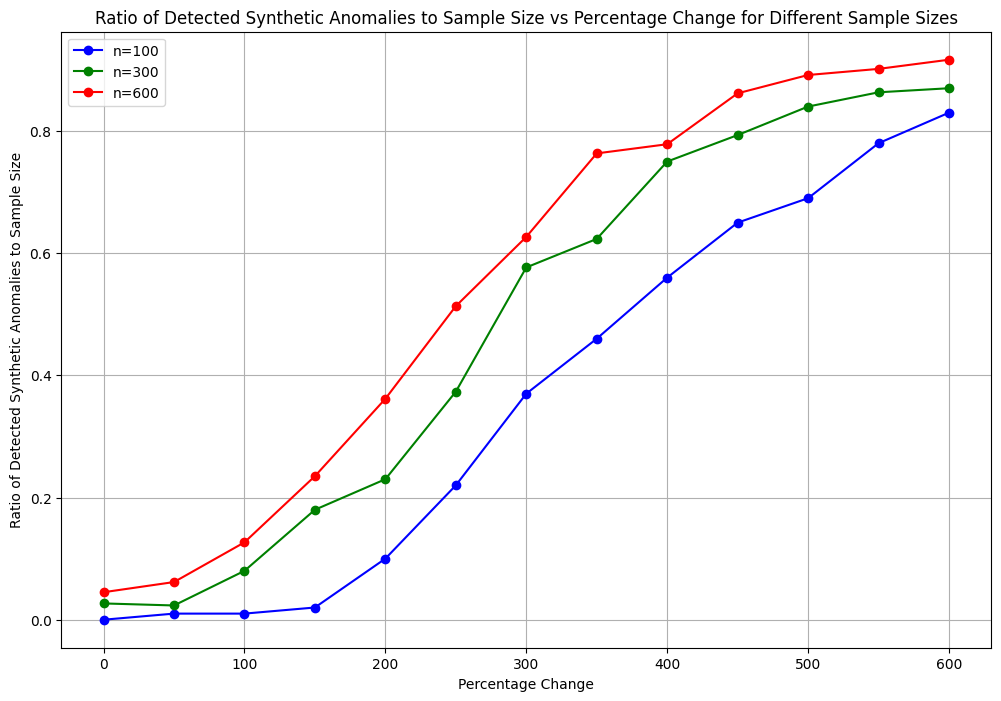

Plot saved to C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/ratio_of_detected_synthetic_anomalies_vs_percentage_change_multiple_sample_sizes.png


In [34]:
# 'Block 13' Note this block is only for plot the results of Isolation Forest for paper
# This block just collect all parts related to the Isolation Forest and run it at once, but note *** you should run block 1, 2, 3, and 6 before runing this block ***
# because we want to plot the results for different sample size (number of synthetic anamolies) and different percentage of change, 
# also the contamination rate will change by the sample size (like sample size 100 --> contamination rate 0.01, sample size 300 --> contamination rate 0.03, sample size 600 --> contamination rate 0.06) for example 0.06 of 10000 dataset sample equals to 600 which matches the sample size

import pandas as pd
import numpy as np
import random
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def modify_residuals(df, day_indices, percentage):
    residual_columns = [f"res i-{lag}" for lag in range(1, 8)]
    for col in residual_columns:
        df[f"modified {col}"] = df[col]  # Copy original residuals to new columns

    for day in day_indices:
        for col in residual_columns:
            if not np.isnan(df.at[day, col]):  # Ensure the value is not NaN
                change_direction = random.choice([-1, 1])
                df.at[day, f"modified {col}"] *= (1 + change_direction * percentage / 100)
    
    # Add a new column to indicate synthetic anomaly
    df['synthetic anomaly'] = None
    df.loc[day_indices, 'synthetic anomaly'] = percentage

def detect_anomalies(df, residual_columns, contamination_rate):
    # Define the modified residual columns
    modified_residual_columns = [f"modified res i-{lag}" for lag in range(1, 8)]

    # Prepare the data for multivariate anomaly detection
    X = df[modified_residual_columns].dropna().values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit Isolation Forest model
    clf = IForest(contamination=contamination_rate)  # Adjust contamination based on expected anomaly rate
    clf.fit(X_scaled)

    # Predict anomalies and add them as a new column
    df['Modified Multivariate Anomaly'] = 0
    df.loc[df[modified_residual_columns].dropna().index, 'Modified Multivariate Anomaly'] = clf.predict(X_scaled)

    # Count the number of detected synthetic anomalies
    detected_synthetic_anomalies = df[(df['synthetic anomaly'].notna()) & (df['Modified Multivariate Anomaly'] == 1)]
    count_of_detected_synthetic_anomalies = len(detected_synthetic_anomalies)
    
    return count_of_detected_synthetic_anomalies

# Load the initial dataset
input_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_IsolationForest_anomalies.xlsx'
df = pd.read_excel(input_file_path)

# Select valid days where 'Multivariate Anomaly' is 0 and the values in the previous 7 days are also 0
valid_days = []
for i in range(7, len(df)):
    if df['Multivariate Anomaly'].iloc[i] == 0 and all(df['Multivariate Anomaly'].iloc[i - j] == 0 for j in range(1, 8)):
        valid_days.append(i)

# Define different sample sizes and percentage changes
sample_sizes = [100, 300, 600]
percentage_changes = list(range(0, 601, 50))
residual_columns = [f"res i-{lag}" for lag in range(1, 8)]
results = {}

# Run the process for different sample sizes and percentage changes
for n in sample_sizes:
    contamination_rate = n / len(df)  # Set contamination rate based on sample size
    detected_anomalies_ratios = []
    random_samples = df.loc[valid_days].sample(n=n, random_state=5).index

    for percentage_change in percentage_changes:
        # Load the dataset to reset any modifications
        df = pd.read_excel(input_file_path)
        
        # Modify residuals
        modify_residuals(df, random_samples, percentage_change)
        
        # Detect anomalies
        count_of_detected_synthetic_anomalies = detect_anomalies(df, residual_columns, contamination_rate)
        
        # Store the result as ratio of detected synthetic anomalies to sample size
        detected_anomalies_ratios.append(count_of_detected_synthetic_anomalies / n)
    
    results[n] = detected_anomalies_ratios

# Plot the results
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Extended color list
for i, n in enumerate(sample_sizes):
    plt.plot(percentage_changes, results[n], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'n={n}')
plt.xlabel('Percentage Change')
plt.ylabel('Ratio of Detected Synthetic Anomalies to Sample Size')
plt.title('Ratio of Detected Synthetic Anomalies to Sample Size vs Percentage Change for Different Sample Sizes')
plt.legend()
plt.grid(True)

# Save the plot with high quality
output_plot_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/ratio_of_detected_synthetic_anomalies_vs_percentage_change_multiple_sample_sizes_IF.png'
plt.savefig(output_plot_path, dpi=300)

# Show the plot
plt.show()

print(f"Plot saved to {output_plot_path}")

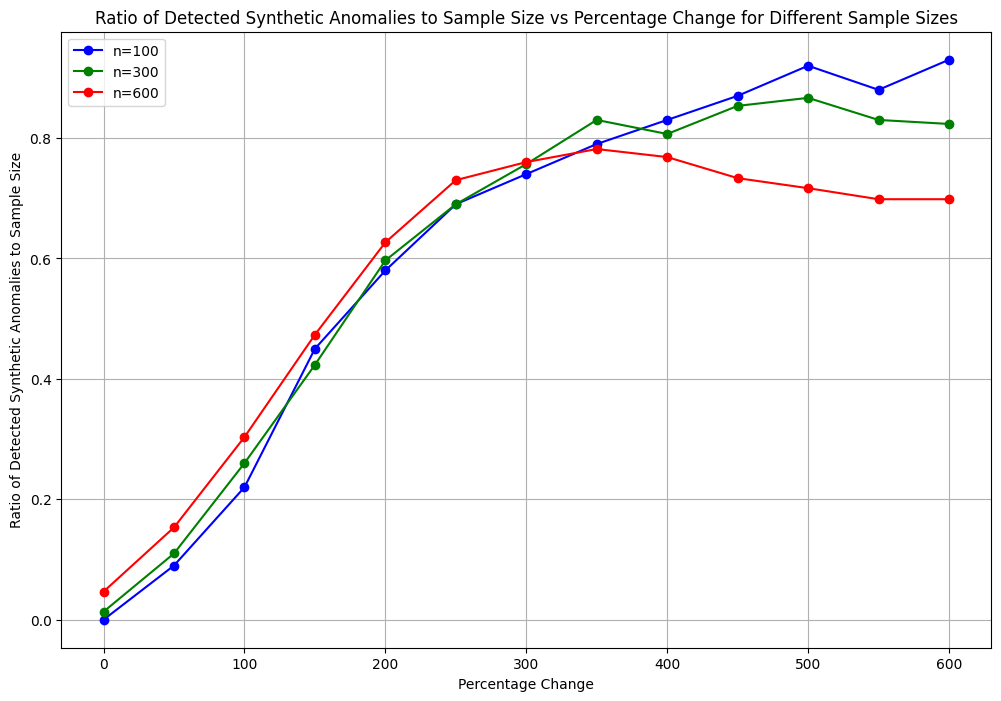

Plot saved to C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/ratio_of_detected_synthetic_anomalies_vs_percentage_change_multiple_sample_sizes_LOF.png


In [40]:
# 'Block 14' Note this block is only for plot the results of Local Outlier Factor for paper
# This block just collect all parts related to the Local Outlier Factor and run it at once, but note *** you should run block 1, 2, 5, and 6 before runing this block ***
# because we want to plot the results for different sample size (number of synthetic anamolies) and different percentage of change
# also the contamination rate will change by the sample size (like sample size 100 --> contamination rate 0.01, sample size 300 --> contamination rate 0.03, sample size 600 --> contamination rate 0.06) for example 0.06 of 10000 dataset sample equals to 600 which matches the sample size



import pandas as pd
import numpy as np
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def modify_residuals(df, day_indices, percentage):
    residual_columns = [f"res i-{lag}" for lag in range(1, 8)]
    for col in residual_columns:
        df[f"modified {col}"] = df[col]  # Copy original residuals to new columns

    for day in day_indices:
        for col in residual_columns:
            if not np.isnan(df.at[day, col]):  # Ensure the value is not NaN
                change_direction = random.choice([-1, 1])
                df.at[day, f"modified {col}"] *= (1 + change_direction * percentage / 100)
    
    # Add a new column to indicate synthetic anomaly
    df['synthetic anomaly'] = None
    df.loc[day_indices, 'synthetic anomaly'] = percentage

def detect_anomalies(df, residual_columns, contamination_rate):
    # Define the modified residual columns
    modified_residual_columns = [f"modified res i-{lag}" for lag in range(1, 8)]

    # Prepare the data for multivariate anomaly detection
    X = df[modified_residual_columns].dropna().values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit LOF model
    lof = LocalOutlierFactor(n_neighbors=7, contamination=contamination_rate)
    y_pred = lof.fit_predict(X_scaled)

    # LOF predicts -1 for anomalies, 1 for normal points
    df['Modified Multivariate Anomaly'] = 0
    df.loc[df[modified_residual_columns].dropna().index, 'Modified Multivariate Anomaly'] = (y_pred == -1).astype(int)

    # Count the number of detected synthetic anomalies
    detected_synthetic_anomalies = df[(df['synthetic anomaly'].notna()) & (df['Modified Multivariate Anomaly'] == 1)]
    count_of_detected_synthetic_anomalies = len(detected_synthetic_anomalies)
    
    return count_of_detected_synthetic_anomalies

# Load the initial dataset
input_file_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/synthetic_days_with_Local_Outlier_Factor_anomalies.xlsx'
df = pd.read_excel(input_file_path)

# Select valid days where 'Multivariate Anomaly' is 0 and the values in the previous 7 days are also 0
valid_days = []
for i in range(7, len(df)):
    if df['Multivariate Anomaly'].iloc[i] == 0 and all(df['Multivariate Anomaly'].iloc[i - j] == 0 for j in range(1, 8)):
        valid_days.append(i)

# Define different sample sizes and percentage changes
sample_sizes = [100, 300, 600]
percentage_changes = list(range(0, 601, 50))
residual_columns = [f"res i-{lag}" for lag in range(1, 8)]
results = {}

# Run the process for different sample sizes and percentage changes
for n in sample_sizes:
    contamination_rate = n / len(df)  # Set contamination rate based on sample size
    detected_anomalies_ratios = []
    random_samples = df.loc[valid_days].sample(n=n, random_state=5).index

    for percentage_change in percentage_changes:
        # Load the dataset to reset any modifications
        df = pd.read_excel(input_file_path)
        
        # Modify residuals
        modify_residuals(df, random_samples, percentage_change)
        
        # Detect anomalies
        count_of_detected_synthetic_anomalies = detect_anomalies(df, residual_columns, contamination_rate)
        
        # Store the result as ratio of detected synthetic anomalies to sample size
        detected_anomalies_ratios.append(count_of_detected_synthetic_anomalies / n)
    
    results[n] = detected_anomalies_ratios

# Plot the results
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Extended color list
for i, n in enumerate(sample_sizes):
    plt.plot(percentage_changes, results[n], marker='o', linestyle='-', color=colors[i % len(colors)], label=f'n={n}')
plt.xlabel('Percentage Change')
plt.ylabel('Ratio of Detected Synthetic Anomalies to Sample Size')
plt.title('Ratio of Detected Synthetic Anomalies to Sample Size vs Percentage Change for Different Sample Sizes')
plt.legend()
plt.grid(True)

# Save the plot with high quality
output_plot_path = 'C:/Users/e16011413/OneDrive - Ulster University/Desktop/UCAmI/UCAmI Anomaly/SyntheticData/ratio_of_detected_synthetic_anomalies_vs_percentage_change_multiple_sample_sizes_LOF.png'
plt.savefig(output_plot_path, dpi=300)

# Show the plot
plt.show()

print(f"Plot saved to {output_plot_path}")